# Imports

In [690]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns

# "Global" Variables

In [160]:
sample_rate = 4 # Quarterly
region = 'England'

bev_lifetime = 12 # Years
phev_lifetime = 15 # Years

horizon = 2050 # How far into the future we're looking

ice_ban = 2030 # The year in which the sale of new ICE vehicles is banned in the UK
phev_ban = 2035 # The year in which the sale of new Hybrid vehicles is banned in the UK

# Convenience Functions

In [39]:
# mask is a way of filtering a dataframe in a chained way
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

# apply_dtypes converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

# Returns the first (and oldest) date (assuming date is the index) of a series or DataFrame
def calculate_t0(data):
    year = int(data.head(1).index[0][:4])
    quarter = data.head(1).index[0][-2:]
    if quarter == 'Q1':
        t0 = year + 0
    elif quarter == 'Q2':
        t0 = year + 0.25
    elif quarter == 'Q3':
        t0 = year + 0.5
    elif quarter == 'Q4':
        t0 = year + 0.75
    return t0

# Returns the last (and most recent) date (assuming date is the index) of a series or DataFrame
def calculate_t_present(data):
    year = int(data.tail(1).index[0][:4])
    quarter = data.tail(1).index[0][-2:]
    if quarter == 'Q1':
        t_present = year + 0
    elif quarter == 'Q2':
        t_present = year + 0.25
    elif quarter == 'Q3':
        t_present = year + 0.5
    elif quarter == 'Q4':
        t_present = year + 0.75    
    return t_present

# Returns an array of numeric dates between t0 and t1 at a specified sample rate
def calculate_date_range(t0, t1, sample_rate):
    return np.linspace(t0, t1, int((t1-t0)*sample_rate) + 1)

# Takes in text based dates (e.g. 2022 Q4) and returns an array of decimalised dates
def convert_dates_to_numeric(data):
    dates = np.zeros(len(data))
    for i in np.arange(len(data)):
        year = int(data.index[i][:4])
        quarter = data.index[i][-2:]
        if quarter == 'Q1':
            d = year + 0
        elif quarter == 'Q2':
            d = year + 0.25
        elif quarter == 'Q3':
            d = year + 0.5
        elif quarter == 'Q4':
            d = year + 0.75
        dates[i] = d
    return dates

# Read in Data

### VEH1153: Vehicles registered for the first time by body type and fuel type

In [4]:
drop_cols_veh1153 = [
    'Units',
]

veh1153 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1153.ods", 
        engine="odf", 
        sheet_name='VEH1153a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Date Interval [note 4]': 'Date Interval',
            'Date [note 4]': 'Date',
            'Other vehicles [note 3]': 'Other vehicles',
            'Gas [note 5]': 'Gas',
            'Other fuel types [note 6]': 'Other fuel types',
            'Plug-in [note 7]': 'Plug-in',
            'Zero emission [note 8]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1153, axis=1)
)

# Convert units from Thousands to real counts
veh1153.iloc[:, 4:] = veh1153.iloc[:, 4:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1153['ICE'] = veh1153['Total'] - veh1153['Plug-in'] - veh1153['Fuel cell electric']

# Remove bracketed text from Dates
veh1153['Date'] = veh1153['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1153.head()

,Geography,Date Interval,Date,BodyType,Petrol,Diesel,Hybrid electric (petrol),Hybrid electric (diesel),Plug-in hybrid electric (petrol),Plug-in hybrid electric (diesel),Battery electric,Range extended electric,Fuel cell electric,Gas,Other fuel types,Total,Plug-in,Zero emission,ICE
374,England,Annual,2001,Cars,1874649.0,405214.0,604.0,3.0,0.0,0.0,81.0,0.0,0.0,1954.0,7.0,2282512.0,81.0,81.0,2282431.0
375,England,Annual,2002,Cars,1793879.0,563102.0,270.0,0.0,0.0,0.0,58.0,0.0,1.0,2311.0,3.0,2359624.0,58.0,59.0,2359565.0
376,England,Annual,2003,Cars,1679322.0,641920.0,351.0,0.0,0.0,0.0,39.0,0.0,3.0,3086.0,6.0,2324727.0,39.0,42.0,2324685.0
377,England,Annual,2004,Cars,1524998.0,749242.0,1442.0,0.0,0.0,0.0,90.0,0.0,2.0,1681.0,8.0,2277463.0,90.0,92.0,2277371.0
378,England,Annual,2005,Cars,1343752.0,794699.0,4997.0,3.0,0.0,0.0,223.0,0.0,4.0,482.0,13.0,2144173.0,223.0,227.0,2143946.0


### VEH1103: Licensed vehicles at the end of the quarter by body type and fuel type

In [5]:
drop_cols_veh1103 = [
    'Units',
]

veh1103 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1103.ods", 
        engine="odf", 
        sheet_name='VEH1103a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Gas [note 4]': 'Gas',
            'Other fuel types [note 5]': 'Other fuel types',
            'Plug-in [note 6]': 'Plug-in',
            'Zero emission [note 7]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1103, axis=1)
)

# Convert units from Thousands to real counts
veh1103.iloc[:, 3:] = veh1103.iloc[:, 3:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1103['ICE'] = veh1103['Total'] - veh1103['Plug-in'] - veh1103['Fuel cell electric']

# Remove bracketed text from Dates
veh1103['Date'] = veh1103['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1103.head()

,Geography,Date,BodyType,Petrol,Diesel,Hybrid electric (petrol),Hybrid electric (diesel),Plug-in hybrid electric (petrol),Plug-in hybrid electric (diesel),Battery electric,Range extended electric,Fuel cell electric,Gas,Other fuel types,Total,Plug-in,Zero emission,ICE
72,England,1994 Q4,Cars,16694257.0,1313637.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,1543.0,192.0,18009710.0,81.0,81.0,18009629.0
73,England,1995 Q4,Cars,16635739.0,1573698.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,2518.0,121.0,18212137.0,61.0,61.0,18212076.0
74,England,1996 Q4,Cars,17149424.0,1811387.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0,3587.0,107.0,18964584.0,79.0,79.0,18964505.0
75,England,1997 Q4,Cars,17505628.0,2031080.0,0.0,0.0,0.0,0.0,101.0,0.0,0.0,5577.0,104.0,19542490.0,101.0,101.0,19542389.0
76,England,1998 Q4,Cars,17744318.0,2247998.0,0.0,0.0,0.0,0.0,140.0,0.0,0.0,8650.0,100.0,20001206.0,140.0,140.0,20001066.0


### LSOA Lookup Data

In [6]:
LAD = 'Bath and North East Somerset' # Target Local Authority District

In [7]:
lsoa_lookup = pd.read_csv('../../data/spatial_data/lsoa_data/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
lsoa_lookup.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
0,E01000001,City of London 001A,E01000001,City of London 001A,U,E09000001,City of London,NaN,1
1,E01000002,City of London 001B,E01000002,City of London 001B,U,E09000001,City of London,NaN,2
2,E01000003,City of London 001C,E01000003,City of London 001C,U,E09000001,City of London,NaN,3
3,E01000005,City of London 001E,E01000005,City of London 001E,U,E09000001,City of London,NaN,4
4,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,U,E09000002,Barking and Dagenham,NaN,5


### Historical Total Vehicle Registration Data for LSOAs

In [702]:
v_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Cars' and Keepership == 'Private' and LicenceStatus == 'Licensed'")
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD] # Filter for target Local Authority (BNES)
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
v_lsoa = v_lsoa[~v_lsoa.index.duplicated(keep='first')]

v_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,361.0,353.0,357.0,352.0,369.0,390.0,382.0,380.0,371.0,372.0,...,390.0,397.0,391.0,393.0,384.0,389.0,406.0,378.0,384.0,386.0
E01014371,502.0,512.0,507.0,524.0,517.0,524.0,524.0,530.0,523.0,512.0,...,537.0,552.0,546.0,557.0,552.0,540.0,538.0,549.0,547.0,557.0
E01014372,495.0,507.0,506.0,509.0,513.0,508.0,506.0,508.0,500.0,479.0,...,548.0,553.0,556.0,552.0,571.0,561.0,588.0,604.0,595.0,591.0
E01014373,753.0,754.0,770.0,768.0,775.0,762.0,773.0,740.0,749.0,759.0,...,680.0,674.0,690.0,688.0,695.0,692.0,684.0,696.0,692.0,703.0
E01014374,752.0,762.0,759.0,756.0,746.0,750.0,741.0,739.0,727.0,718.0,...,632.0,627.0,632.0,637.0,634.0,633.0,637.0,628.0,627.0,641.0


### Historical Electric Vehicle Registration Data for LSOAs by Propulsion Type

In [9]:
ev_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0145.csv', dtype = apply_dtypes(4, 56), na_values=['[c]', '[x]'])
    .query("Keepership == 'Private'")
    .drop(columns = ['Keepership', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

ev_lsoa.head()

,Fuel,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,Battery electric,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014370,Plug-in hybrid electric (petrol),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014370,Total,13.0,12.0,10.0,11.0,11.0,8.0,6.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,Battery electric,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,Plug-in hybrid electric (diesel),NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This now needs to be disaggregated by propulsion type.

#### Historical BEV Registration Data for LSOAs

In [10]:
bev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Battery electric' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
bev_lsoa = bev_lsoa[~bev_lsoa.index.duplicated(keep='first')]

bev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,7.0,5.0,5.0,5.0,NaN,5.0,5.0,5.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,10.0,12.0,11.0,11.0,11.0,9.0,7.0,7.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,20.0,17.0,18.0,18.0,15.0,15.0,10.0,8.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Historical PHEV Registration Data for LSOAs

In [11]:
phev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Plug-in hybrid electric (petrol)' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
phev_lsoa = phev_lsoa[~phev_lsoa.index.duplicated(keep='first')]

phev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,5.0,NaN,NaN,NaN,NaN,6.0,5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,12.0,11.0,10.0,9.0,8.0,7.0,5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Historical EV Registration Data for LSOAs

In [12]:
total_ev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Total' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
total_ev_lsoa = total_ev_lsoa[~total_ev_lsoa.index.duplicated(keep='first')]

total_ev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,13.0,12.0,10.0,11.0,11.0,8.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,10.0,11.0,10.0,10.0,7.0,7.0,7.0,6.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,12.0,9.0,9.0,8.0,8.0,11.0,10.0,9.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,14.0,15.0,15.0,15.0,15.0,13.0,11.0,11.0,10.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,34.0,30.0,30.0,29.0,24.0,23.0,16.0,13.0,10.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Historical ICE Registration Data for LSOAs

The difference between the total vehicle and EV registration is assumed to be the ICE registration.

In [13]:
ice_lsoa = v_lsoa.subtract(total_ev_lsoa)
ice_lsoa = ice_lsoa[ice_lsoa.columns[::-1]]
ice_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,348.0,341.0,347.0,341.0,358.0,382.0,376.0,NaN,NaN,NaN,...,390.0,397.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014371,492.0,501.0,497.0,514.0,510.0,517.0,517.0,524.0,NaN,NaN,...,537.0,552.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014372,483.0,498.0,497.0,501.0,505.0,497.0,496.0,499.0,491.0,472.0,...,548.0,553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014373,739.0,739.0,755.0,753.0,760.0,749.0,762.0,729.0,739.0,750.0,...,680.0,674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014374,718.0,732.0,729.0,727.0,722.0,727.0,725.0,726.0,717.0,709.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Interpolate Missing Registration Data

Historical registration data is not reported if the number of registered vehicles in an LSOA is: $0 < n < 5$.

Therefore, missing registration data is interpolated in order to better capture trends in EV registration.

In [703]:
# Interpolates missing registration data
def interpolate_registration_data(data, sample_rate):
    def interpolate_col(col):
        dates = calculate_date_range(calculate_t0(col), calculate_t_present(col), sample_rate)
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    interpolated_df = data.apply(interpolate_col, axis=0)
    
    return interpolated_df

In [14]:
bev_lsoa_i = interpolate_registration_data(bev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
phev_lsoa_i = interpolate_registration_data(phev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_ev_lsoa_i = interpolate_registration_data(total_ev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
ice_lsoa_i = interpolate_registration_data(ice_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_lsoa_i = interpolate_registration_data(v_lsoa.T.iloc[::-1], sample_rate=sample_rate)

# Approximate Vehicle Retirement Rates

I am assuming that the retirement rate of ICE vehicles is equal to the quarterly number of retired ICEs divided by the total number of registered ICEs. This represents the proportion of the ICE stock that retire each quarter. The inverse of this would give an estimate for the average lifespan of an ICE. This works out at around 18 years.

In [99]:
# Number of ICE vehicles currently registered in the "region"
n_ice = veh1103.loc[(veh1103['Geography'] == region), 'ICE'].iloc[-1]
n_ice

26459296.0

In [100]:
# ICE Retirements
ice_retirements = (veh1153.loc[(veh1153['Geography'] == region) & (veh1153['Date Interval'] == 'Quarterly')].set_index('Date').loc[:, 'ICE'] - 
                       veh1103.loc[(veh1103['Geography'] == region)].set_index('Date').loc[:, 'ICE'].diff()).mean() # Per Quarter
ice_retirement_rate = ice_retirements/n_ice
ice_retirement_rate

0.013699838888672334

In [101]:
bev_retirement_rate = 1/(4*bev_lifetime)
bev_retirement_rate

0.020833333333333332

In [102]:
phev_retirement_rate = 1/(4*phev_lifetime)
phev_retirement_rate

0.016666666666666666

# Estimate New Vehicle Registrations in each LSOA

In [103]:
rolling_average_window = 8

<Axes: title={'center': 'Estimated New BEV Registrations in each LSOA'}>

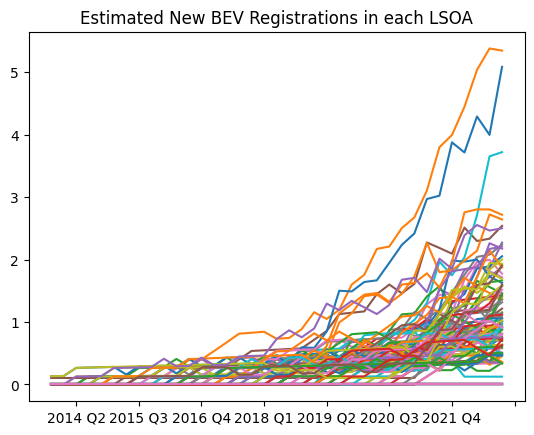

In [104]:
new_bev_lsoa = bev_lsoa_i.diff().add(bev_lsoa_i*bev_retirement_rate) # Approximate new BEV registrations per quarter
new_bev_lsoa[new_bev_lsoa < 0] = 0

# Smooth data by taking a rolling average over 8 quarters (2 years)
smoothed_new_bev_lsoa = new_bev_lsoa.rolling(rolling_average_window).mean()
smoothed_new_bev_lsoa.plot(legend=False, title='Estimated New BEV Registrations in each LSOA')

<Axes: title={'center': 'Estimated New PHEV Registrations in each LSOA'}>

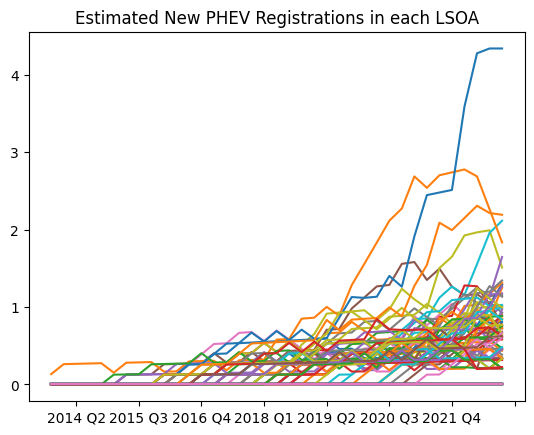

In [105]:
new_phev_lsoa = phev_lsoa_i.diff().add(phev_lsoa_i*phev_retirement_rate) # Approximate new PHEV registrations per quarter
new_phev_lsoa[new_phev_lsoa < 0] = 0

# Smooth data by taking a rolling average over 8 quarters (2 years)
smoothed_new_phev_lsoa = new_phev_lsoa.rolling(rolling_average_window).mean()
smoothed_new_phev_lsoa.plot(legend=False, title='Estimated New PHEV Registrations in each LSOA')

<Axes: title={'center': 'Estimated New EV Registrations in each LSOA'}>

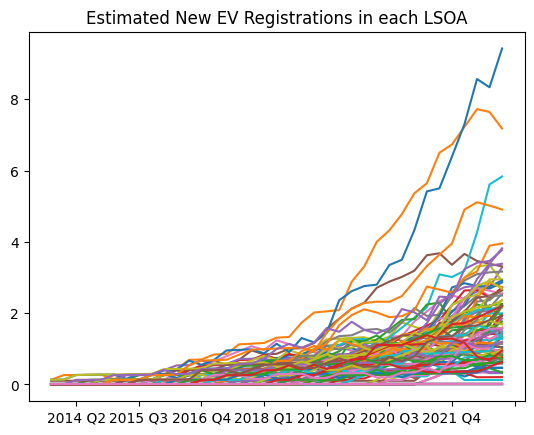

In [106]:
smoothed_new_ev_lsoa = sum([smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])
smoothed_new_ev_lsoa.plot(legend=False, title='Estimated New EV Registrations in each LSOA')

<Axes: title={'center': 'Estimated New ICE Registrations in each LSOA'}>

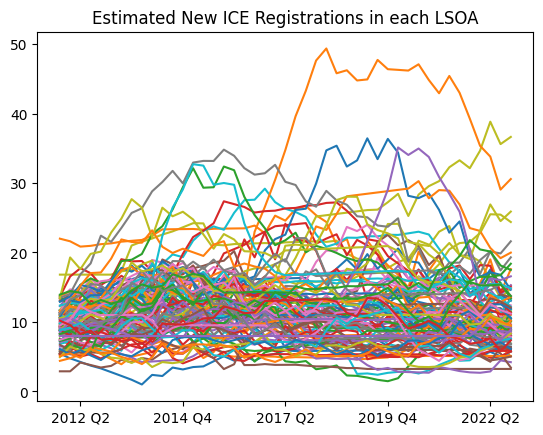

In [107]:
new_ice_lsoa = ice_lsoa_i.diff().add(ice_lsoa_i*ice_retirement_rate) # Approximate new ICE registrations per quarter
new_ice_lsoa[new_ice_lsoa < 0] = 0

# Smooth data by taking a rolling average over 8 quarters (2 years)
smoothed_new_ice_lsoa = new_ice_lsoa.rolling(rolling_average_window).mean()
smoothed_new_ice_lsoa.plot(legend=False, title='Estimated New ICE Registrations in each LSOA')

<Axes: title={'center': 'Estimated New Vehicle Registrations in each LSOA'}>

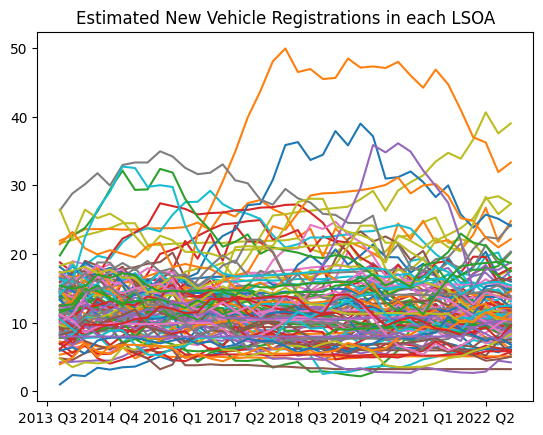

In [108]:
# Approximate new vehicle registrations per quarter (assuming ice retirement rate)
smoothed_new_vehicles_lsoa = sum([smoothed_new_ice_lsoa, smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])
smoothed_new_vehicles_lsoa.plot(legend=False, title='Estimated New Vehicle Registrations in each LSOA')

# Forecasting the Sales Share for Each Propulsion Type

Given ICE and PHEV New Sale Bans

In [ ]:
def calculate_sales_share(target, parent, ban, value_at_ban):
    sales_share = target.divide(parent) # Target = Vehicle time, parent = Parent vehicle type

    dates = convert_dates_to_numeric(sales_share) # Historical Dates
    date_range = calculate_date_range(calculate_t0(sales_share), t1=horizon, sample_rate=sample_rate) # Current and Future Dates

    sales_share['Date_numeric'] = dates
    sales_share = sales_share.set_index('Date_numeric')
    sales_share = sales_share.reindex(date_range)

    # Linear Interpolation

    sales_share.loc[ban, :] = value_at_ban # 0 if banned vehicle type, 1 if beneficiary.
    sales_share = sales_share.interpolate()
    return sales_share

In [656]:
ev_sales_share_lsoa = calculate_sales_share(smoothed_new_ev_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 1)
ice_sales_share_lsoa = calculate_sales_share(smoothed_new_ice_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 0)
bev_sales_share_lsoa = calculate_sales_share(smoothed_new_bev_lsoa, smoothed_new_ev_lsoa, phev_ban, 1)
phev_sales_share_lsoa = calculate_sales_share(smoothed_new_phev_lsoa, smoothed_new_ev_lsoa, phev_ban, 0)

<Axes: title={'center': 'Share of new vehicles that are EVs in each LSOA'}, xlabel='Date_numeric'>

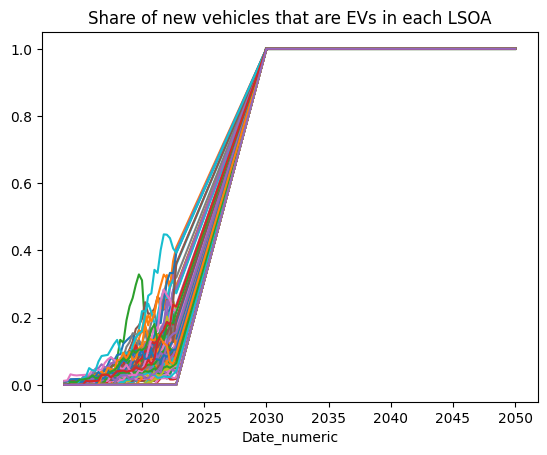

In [657]:
ev_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are EVs in each LSOA')

<Axes: title={'center': 'Share of new vehicles that are ICEs in each LSOA'}, xlabel='Date_numeric'>

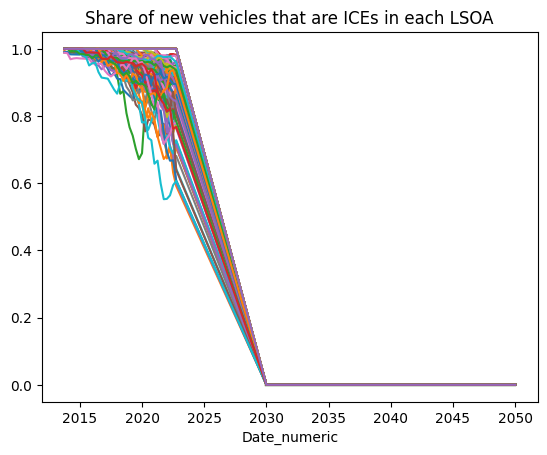

In [658]:
ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA')

<Axes: title={'center': 'Share of new EVs that are BEVs in each LSOA'}, xlabel='Date_numeric'>

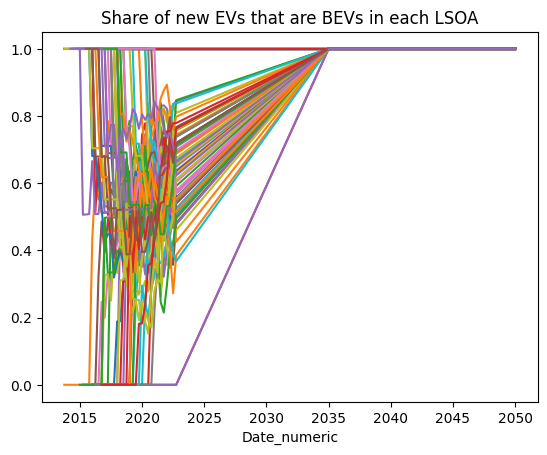

In [659]:
bev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are BEVs in each LSOA')

<Axes: title={'center': 'Share of new EVs that are PHEVs in each LSOA'}, xlabel='Date_numeric'>

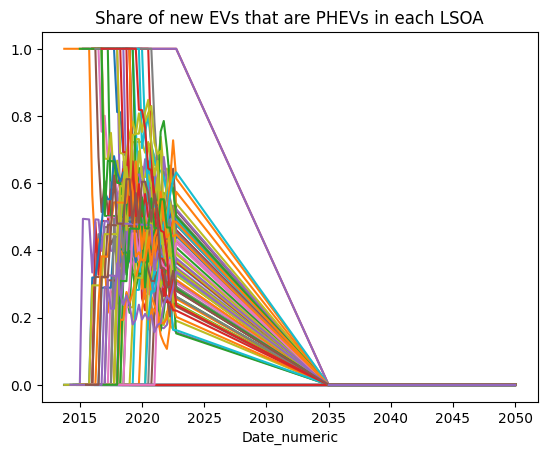

In [660]:
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA')

# Incorporating Anticipatory behaviour

Have one linear function that trends towards 0 or 1 share of vehicle propulsion type.

Multiply this by an anticipatory function that expontentially increases/decreases up until the relevant ban.

The shape of this curve dictates the extent of anticipatory behaviour prior to a ban.

This should only be used for the legacy vehicles with the disrupter vehicles' sales share being inferred.

As the linear function ends at 0 share on the date of the ban, the exponential function is constrained at 0 at that point. This should look pretty cool!

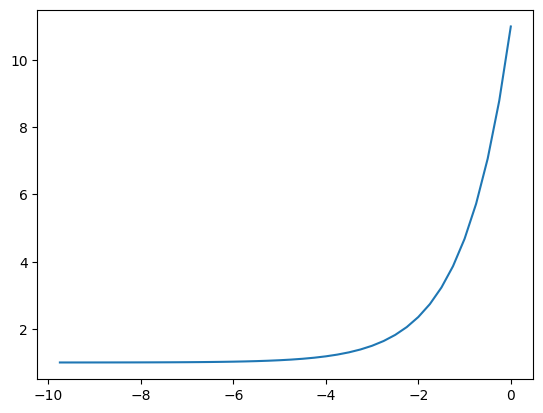

In [661]:
anticipatory_period = 10

x = np.linspace(-(anticipatory_period - (1/sample_rate)), 0, 40) # 10 years (40 quarters)

# ICE Anticipatory Parameters
a = 10
b = 1

y_ice = a * np.exp(b * x) + 1

# PHEV Anticipatory Parameters
c = 10
d = 1

y_phev = c * np.exp(d * x) + 1

plt.plot(x, y_ice)

In [662]:
ice_sales_share_lsoa.loc[ice_ban - 9.75 : ice_ban] = ice_sales_share_lsoa.loc[ice_ban - 9.75 : ice_ban].multiply(y_ice, axis=0)
ev_sales_share_lsoa = 1 - ice_sales_share_lsoa

In [663]:
phev_sales_share_lsoa[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban] = phev_sales_share_lsoa.loc[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban].multiply(y_phev, axis=0)
bev_sales_share_lsoa = 1 - phev_sales_share_lsoa

<Axes: xlabel='Date_numeric'>

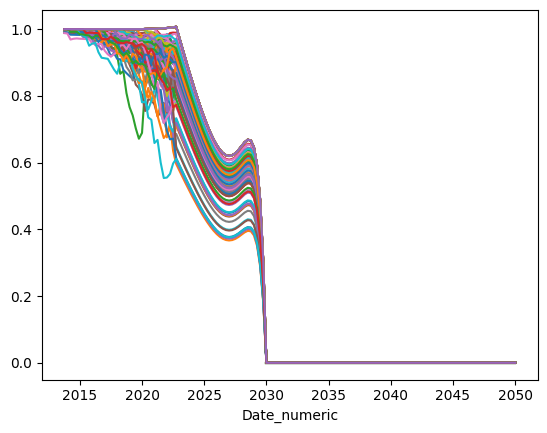

In [682]:
ice_sales_share_lsoa.plot(legend=False)

<Axes: xlabel='Date_numeric'>

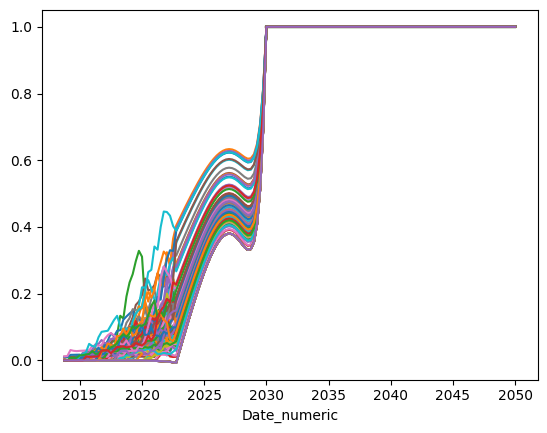

In [683]:
ev_sales_share_lsoa.plot(legend=False)

<Axes: xlabel='Date_numeric'>

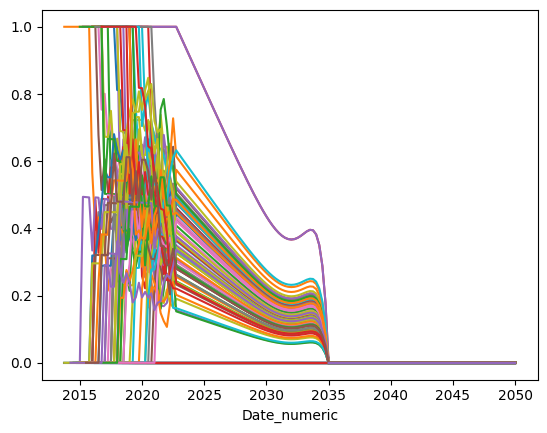

In [684]:
phev_sales_share_lsoa.plot(legend=False)

<Axes: xlabel='Date_numeric'>

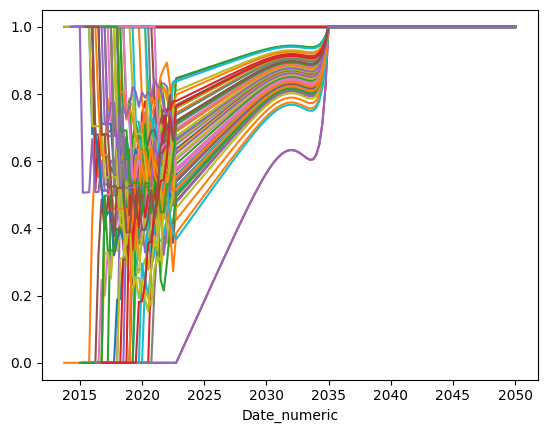

In [685]:
bev_sales_share_lsoa.plot(legend=False)

# Forecasting New Vehicle Registrations

In [668]:
forecast_dates = calculate_date_range(t0=calculate_t_present(bev_lsoa_i), t1=horizon, sample_rate=4)
forecast_dates

array([2022.75, 2023.  , 2023.25, 2023.5 , 2023.75, 2024.  , 2024.25,
       2024.5 , 2024.75, 2025.  , 2025.25, 2025.5 , 2025.75, 2026.  ,
       2026.25, 2026.5 , 2026.75, 2027.  , 2027.25, 2027.5 , 2027.75,
       2028.  , 2028.25, 2028.5 , 2028.75, 2029.  , 2029.25, 2029.5 ,
       2029.75, 2030.  , 2030.25, 2030.5 , 2030.75, 2031.  , 2031.25,
       2031.5 , 2031.75, 2032.  , 2032.25, 2032.5 , 2032.75, 2033.  ,
       2033.25, 2033.5 , 2033.75, 2034.  , 2034.25, 2034.5 , 2034.75,
       2035.  , 2035.25, 2035.5 , 2035.75, 2036.  , 2036.25, 2036.5 ,
       2036.75, 2037.  , 2037.25, 2037.5 , 2037.75, 2038.  , 2038.25,
       2038.5 , 2038.75, 2039.  , 2039.25, 2039.5 , 2039.75, 2040.  ,
       2040.25, 2040.5 , 2040.75, 2041.  , 2041.25, 2041.5 , 2041.75,
       2042.  , 2042.25, 2042.5 , 2042.75, 2043.  , 2043.25, 2043.5 ,
       2043.75, 2044.  , 2044.25, 2044.5 , 2044.75, 2045.  , 2045.25,
       2045.5 , 2045.75, 2046.  , 2046.25, 2046.5 , 2046.75, 2047.  ,
       2047.25, 2047

In [669]:
new_ev_lsoa_forecast = ev_sales_share_lsoa.loc[forecast_dates, :].multiply(smoothed_new_vehicles_lsoa.iloc[-1], axis='columns')
new_ice_lsoa_forecast = ice_sales_share_lsoa.loc[forecast_dates, :].multiply(smoothed_new_vehicles_lsoa.iloc[-1], axis='columns')
new_bev_lsoa_forecast = bev_sales_share_lsoa.loc[forecast_dates, :].multiply(new_ev_lsoa_forecast, axis='columns')
new_phev_lsoa_forecast = phev_sales_share_lsoa.loc[forecast_dates, :].multiply(new_ev_lsoa_forecast, axis='columns')

new_ev_lsoa_forecast[new_ev_lsoa_forecast < 0] = 0
new_ice_lsoa_forecast[new_ice_lsoa_forecast < 0] = 0
new_bev_lsoa_forecast[new_bev_lsoa_forecast < 0] = 0
new_phev_lsoa_forecast[new_phev_lsoa_forecast < 0] = 0

<Axes: title={'center': 'Forecasts for the number of New EVs by LSOA'}, xlabel='Date_numeric'>

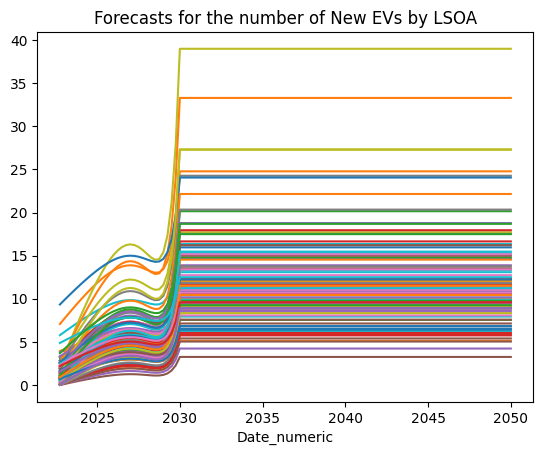

In [670]:
new_ev_lsoa_forecast.plot(legend=False, title='Forecasts for the number of New EVs by LSOA')

<Axes: title={'center': 'Forecasts for the number of New ICEs by LSOA'}, xlabel='Date_numeric'>

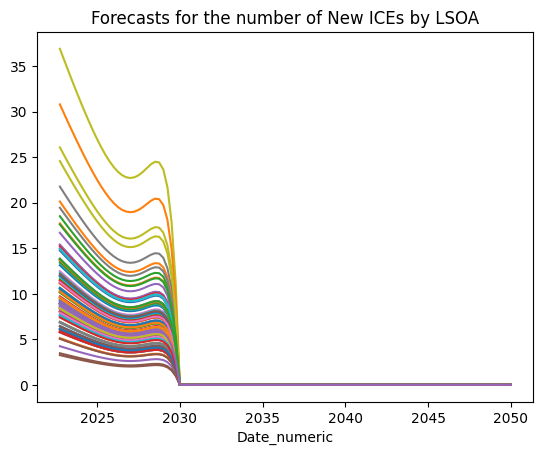

In [671]:
new_ice_lsoa_forecast.plot(legend=False, title='Forecasts for the number of New ICEs by LSOA')

<Axes: title={'center': 'Forecasts for the number of New BEVs by LSOA'}, xlabel='Date_numeric'>

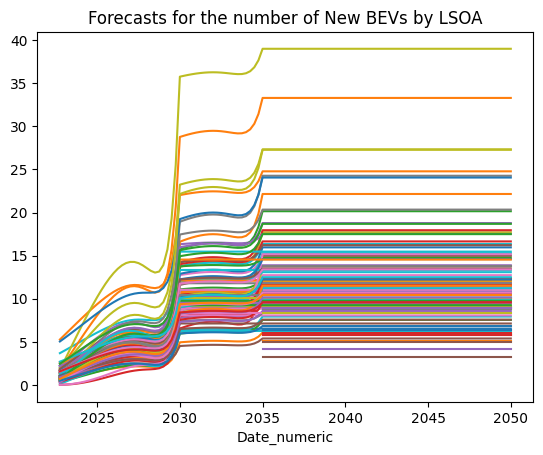

In [672]:
new_bev_lsoa_forecast.plot(legend=False, title='Forecasts for the number of New BEVs by LSOA')

<Axes: title={'center': 'Forecasts for the number of New PHEVs by LSOA'}, xlabel='Date_numeric'>

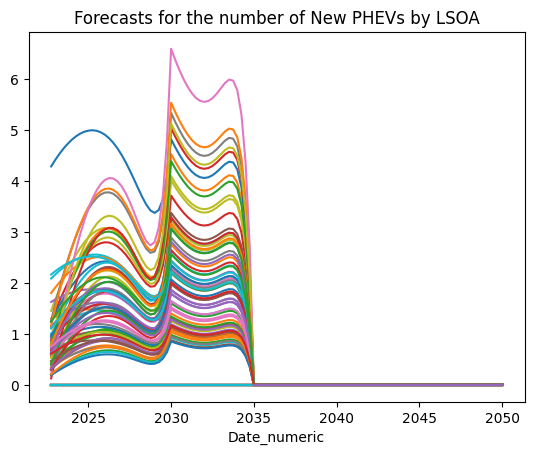

In [673]:
new_phev_lsoa_forecast.plot(legend=False, title='Forecasts for the number of New PHEVs by LSOA')

# Combining Vehicle Retirements

In [674]:
bev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=v_lsoa.index.values, dtype=float)
phev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=v_lsoa.index.values, dtype=float)
ice_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=v_lsoa.index.values,dtype=float)

bev_forecast_lsoa.iloc[0] = bev_lsoa_i.iloc[-1]
phev_forecast_lsoa.iloc[0] = phev_lsoa_i.iloc[-1]
ice_forecast_lsoa.iloc[0] = ice_lsoa_i.iloc[-1]

In [675]:
for i in range(1, len(forecast_dates)): # Need to update from "for loop"
    bev_forecast_lsoa.iloc[i] = bev_forecast_lsoa.iloc[i-1] + new_bev_lsoa_forecast.iloc[i] - bev_retirement_rate * bev_forecast_lsoa.iloc[i-1]
    phev_forecast_lsoa.iloc[i] = phev_forecast_lsoa.iloc[i-1] + new_phev_lsoa_forecast.iloc[i] - phev_retirement_rate * phev_forecast_lsoa.iloc[i-1]
    ice_forecast_lsoa.iloc[i] = ice_forecast_lsoa.iloc[i-1] + new_ice_lsoa_forecast.iloc[i] - ice_retirement_rate * ice_forecast_lsoa.iloc[i-1]

number_of_bevs_lsoa = round(bev_forecast_lsoa)
phev_forecast_lsoa = round(phev_forecast_lsoa)
ice_forecast_lsoaa = round(ice_forecast_lsoa)

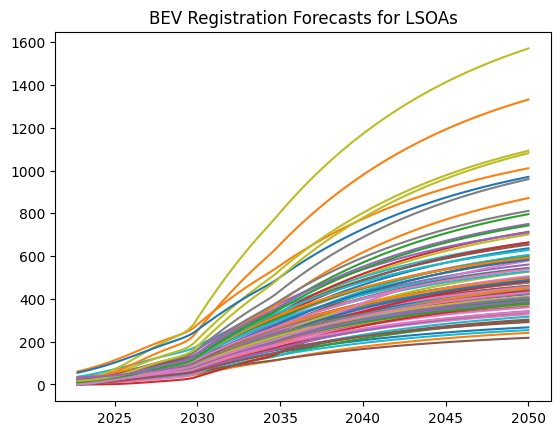

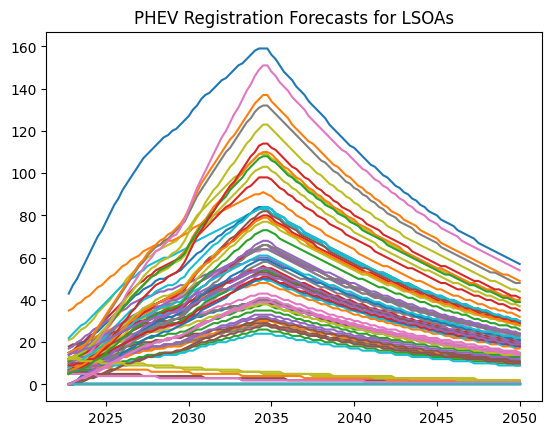

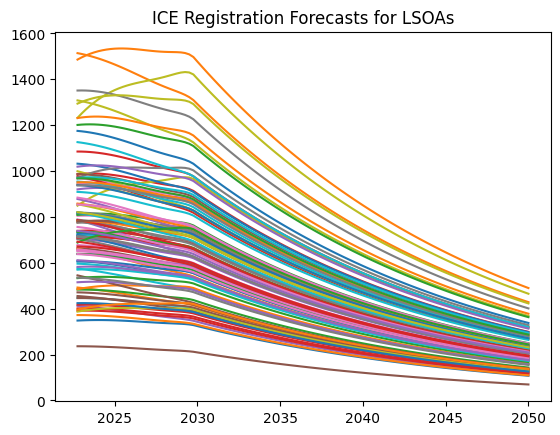

In [699]:
bev_forecast_lsoa.plot(legend=False, title='BEV Registration Forecasts for LSOAs')
phev_forecast_lsoa.plot(legend=False, title = 'PHEV Registration Forecasts for LSOAs')
ice_forecast_lsoa.plot(legend=False, title = 'ICE Registration Forecasts for LSOAs')
plt.show()

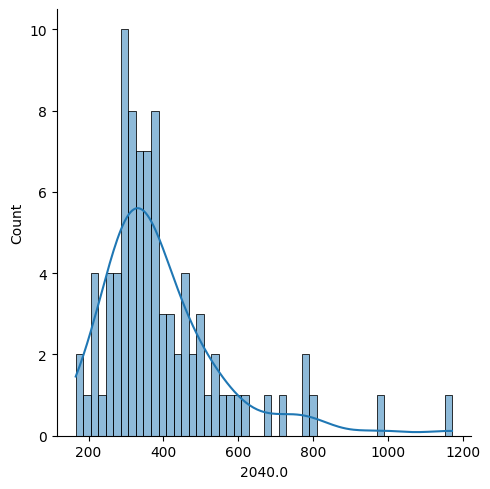

In [698]:
sns.displot(bev_forecast_lsoa.loc[2040], kde=True, bins=50)

# Forecasting for Individual LSOAs

Text(0.5, 1.0, 'Vehicle Stock Forecasts for LSOA E01014381')

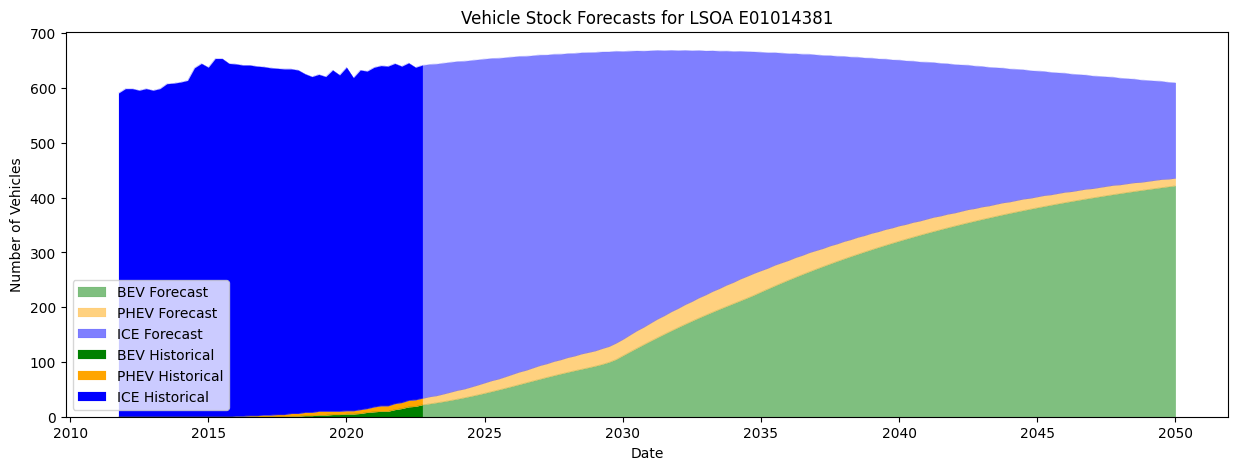

In [700]:
id = 10
bev_forecast_single_lsoa = bev_forecast_lsoa.iloc[:, id]
bev_forecast_single_lsoa.name = 'BEV Forecast'
phev_forecast_single_lsoa = phev_forecast_lsoa.iloc[:, id]
phev_forecast_single_lsoa.name = 'PHEV Forecast'
ice_forecast_single_lsoa = ice_forecast_lsoa.iloc[:, id]
ice_forecast_single_lsoa.name = 'ICE Forecast'

future_vehicles = pd.concat([bev_forecast_single_lsoa, phev_forecast_single_lsoa, ice_forecast_single_lsoa], axis=1)

historical_ice_single_lsoa = ice_lsoa_i.iloc[:, id]
historical_ice_single_lsoa.name = 'ICE Historical'
historical_bev_single_lsoa = bev_lsoa_i.iloc[:, id]
historical_bev_single_lsoa.name = 'BEV Historical'
historical_phev_single_lsoa = phev_lsoa_i.iloc[:, id]
historical_phev_single_lsoa.name = 'PHEV Historical'

historical_vehicles = pd.concat([historical_bev_single_lsoa, historical_phev_single_lsoa, historical_ice_single_lsoa], axis=1).dropna()
historical_dates = convert_dates_to_numeric(historical_vehicles)
historical_vehicles['dates_numeric'] = historical_dates
historical_vehicles = historical_vehicles.set_index('dates_numeric')

fig, ax = plt.subplots(figsize=(15, 5))
future_vehicles.plot.area(ax=ax, color=['green', 'orange', 'blue'], alpha=0.5, linewidth=0.1)
historical_vehicles.plot.area(ax=ax, color=['green', 'orange', 'blue'], linewidth=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('Vehicle Stock Forecasts for LSOA {}'.format(bev_forecast_lsoa.iloc[:, id].name))

Text(0.5, 1.0, 'Vehicle Stock Forecasts for LSOA E01014381')

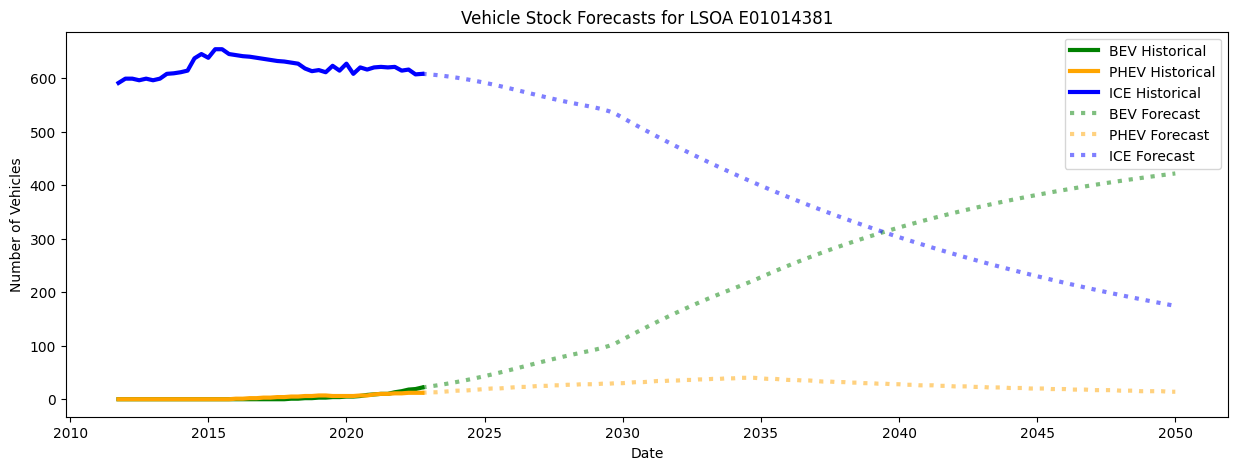

In [701]:
fig, ax = plt.subplots(figsize=(15, 5))
historical_vehicles.plot(ax=ax, color=['green', 'orange', 'blue'], linewidth=3)
future_vehicles.plot(ax=ax, color=['green', 'orange', 'blue'], alpha=0.5, linewidth=3, linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('Vehicle Stock Forecasts for LSOA {}'.format(bev_forecast_lsoa.iloc[:, id].name))

Text(0.5, 1.0, 'BEV Stock Forecasts for LSOA E01014381')

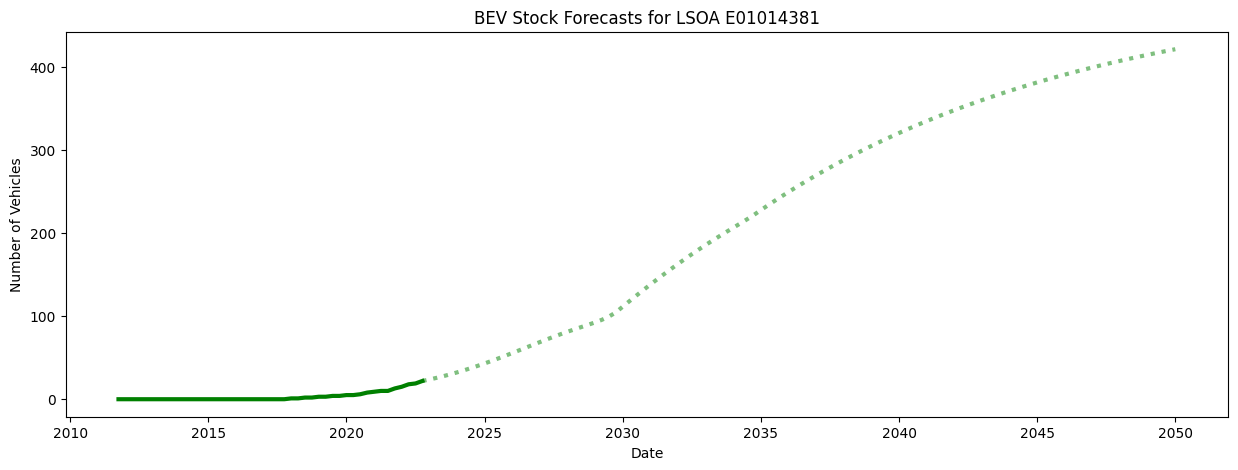

In [679]:
fig, ax = plt.subplots(figsize=(15, 5))
historical_vehicles['BEV Historical'].plot(ax=ax, color=['green'], linewidth=3)
future_vehicles['BEV Forecast'].plot(ax=ax, color=['green'], alpha=0.5, linewidth=3, linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('BEV Stock Forecasts for LSOA {}'.format(bev_forecast_lsoa.iloc[:, id].name))

Text(0.5, 1.0, 'PHEV Stock Forecasts for LSOA E01014381')

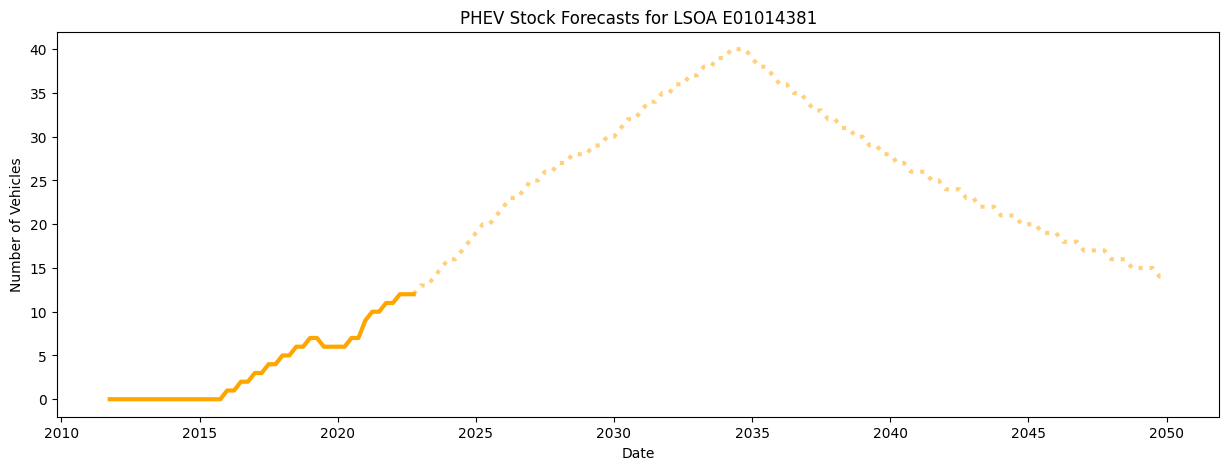

In [680]:
fig, ax = plt.subplots(figsize=(15, 5))
historical_vehicles['PHEV Historical'].plot(ax=ax, color=['orange'], linewidth=3)
future_vehicles['PHEV Forecast'].plot(ax=ax, color=['orange'], alpha=0.5, linewidth=3, linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('PHEV Stock Forecasts for LSOA {}'.format(phev_forecast_lsoa.iloc[:, id].name))

Text(0.5, 1.0, 'ICE Stock Forecasts for LSOA E01014381')

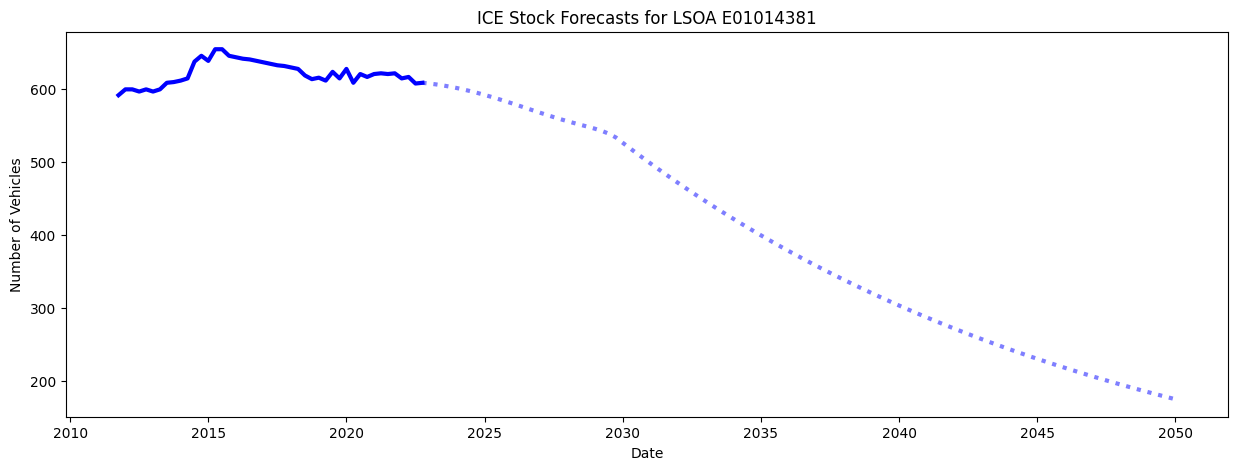

In [681]:
fig, ax = plt.subplots(figsize=(15, 5))
historical_vehicles['ICE Historical'].plot(ax=ax, color=['blue'], linewidth=3)
future_vehicles['ICE Forecast'].plot(ax=ax, color=['blue'], alpha=0.5, linewidth=3, linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('ICE Stock Forecasts for LSOA {}'.format(ice_forecast_lsoa.iloc[:, id].name))